In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import defaultdict
import matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV, RandomizedSearchCV, 
    TimeSeriesSplit, validation_curve
)
from sklearn.exceptions import DataConversionWarning, UndefinedMetricWarning
from sklearn.externals import joblib

import lightgbm as lgbm

from scipy import sparse

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
%config InlineBackend.figure_format = 'retina'

In [3]:
Dtrain = pd.read_csv('../Amazon_Review_commons/Dtrain.csv')
Dtest = pd.read_csv('../Amazon_Review_commons/Dtest.csv')

In [4]:
cunt = joblib.load('../Amazon_Review_commons/countVectorizer.model')

/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.1 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
def get_summary_grid(grid):
    parms = list(grid.param_grid.keys())
    columns = ['Iter #']
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in grid.param_grid.keys():
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[1:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
    for k, v in grid.param_grid.items():
        items *= len(v)
    df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [6]:
def get_summary_randomized(grid):
    parms = list(grid.param_distributions.keys())
    columns = []
    scorings = grid.scoring
    for scoring in scorings:
        for typ in ['train', 'test']:
            columns.append(f'{typ}_{scoring}')
    columns.extend(['fit_time', 'score_time'])
    for param in parms:
        columns.append(param)
    df = pd.DataFrame(columns=columns)
    cv_res = grid.cv_results_
    for col in columns[0:-len(parms)]:
        df[col] = cv_res['mean_' + col]
    items = 1
#     for k, v in grid.param_distributions.items():
#         items *= len(v)
#     df['Iter #'] = np.array(range(items)) + 1
    res = defaultdict(list)
    for each in grid.cv_results_['params']:
        for p in parms:
            res[p].append(each[p])
    for k, v in res.items():
        df[k] = v
    return df

In [7]:
tscv = TimeSeriesSplit(n_splits=5)

### Loading the data

In [22]:
Dtrain_bow = sparse.load_npz('../Amazon_Review_commons/BOW_train.npz')
Dtest_bow = sparse.load_npz('../Amazon_Review_commons/BOW_test.npz')

In [23]:
yTrain_bow = Dtrain.Polarity.apply(lambda x: 1 if x == 'positive' else 0).values
yTest_bow = Dtest.Polarity.apply(lambda x: 1 if x == 'positive' else 0).values

In [25]:
Dtrain_bow = Dtrain_bow.astype('float64')
Dtest_bow = Dtest_bow.astype('float64')

In [26]:
yTrain_bow = yTrain_bow.astype('float64')
yTest_bow = yTest_bow.astype('float64')

### GridSearch 1 -- for base learners

In [43]:
params = {
    'max_depth': [2, 4, 6],  # Typically small value for low variance 
    'subsample': [0.5, 0.75, 1.0], # Row sampling like Random Forest 
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],  # Column sampling like Random Forest
    'num_leaves': [2**2, 2**4, 2**6]  # Should be according to the max_depth (small)
}

In [44]:
estimator = lgbm.LGBMClassifier(random_state=42, 
                                silent=False, 
                                n_jobs=1, 
                                class_weight='balanced',
                                objective='binary')

In [45]:
grid = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [46]:
features = Dtrain_bow
labels = yTrain_bow

In [ ]:
grid.fit(features, labels)  ## Only 11.2 minutes..Impressive (540 fits)

In [48]:
grid_res = get_summary_grid(grid)
grid_res.sort_values('test_f1', ascending=False).head()

,Iter #,train_f1,test_f1,train_precision,test_precision,train_roc_auc,test_roc_auc,train_recall,test_recall,train_accuracy,test_accuracy,fit_time,score_time,max_depth,subsample,colsample_bytree,num_leaves
24,25,0.844104,0.834055,0.971039,0.957395,0.885451,0.865489,0.746522,0.738884,0.759751,0.752279,13.589072,1.642422,6,0.50,0.3,64
25,26,0.844104,0.834055,0.971039,0.957395,0.885451,0.865489,0.746522,0.738884,0.759751,0.752279,13.761963,1.505177,6,0.75,0.3,64
26,27,0.844104,0.834055,0.971039,0.957395,0.885451,0.865489,0.746522,0.738884,0.759751,0.752279,13.485010,1.523830,6,1.00,0.3,64
80,81,0.843982,0.832883,0.971800,0.957067,0.888214,0.864574,0.745884,0.737232,0.759743,0.750716,14.785540,1.506392,6,1.00,0.7,64
79,80,0.843982,0.832883,0.971800,0.957067,0.888214,0.864574,0.745884,0.737232,0.759743,0.750716,14.866151,1.489506,6,0.75,0.7,64


In [49]:
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1]
}

In [50]:
estimator = grid.best_estimator_

In [51]:
grid2 = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [52]:
grid2.fit(features, labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.3, importance_type='split', learning_rate=0.1,
        max_depth=6, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=1, num_leaves=64,
        objective='binary', random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=0.5, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300], 'learning_rate': [0.001, 0.01, 0.1]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'f1', 'precision', 'roc_auc', 'recall', 'accuracy'},
       verbose=2)

In [53]:
grid_res = get_summary_grid(grid2)
grid_res.sort_values('test_f1', ascending=False).head()

,Iter #,train_f1,test_f1,train_precision,test_precision,train_roc_auc,test_roc_auc,train_recall,test_recall,train_accuracy,test_accuracy,fit_time,score_time,n_estimators,learning_rate
8,9,0.889867,0.875543,0.977796,0.961439,0.927231,0.895807,0.816448,0.803758,0.823962,0.807486,31.668525,5.812992,300,0.10
7,8,0.874611,0.862082,0.975261,0.960278,0.912761,0.886068,0.792796,0.782127,0.801964,0.789148,24.660365,3.557875,200,0.10
6,7,0.844104,0.834055,0.971039,0.957395,0.885451,0.865489,0.746522,0.738884,0.759751,0.752279,14.051421,1.829090,100,0.10
5,6,0.791381,0.782244,0.964765,0.951377,0.839670,0.825134,0.670909,0.664200,0.691811,0.688310,41.283668,6.901680,300,0.01
4,5,0.778941,0.770528,0.964457,0.951537,0.830999,0.817422,0.653440,0.647491,0.677039,0.675108,28.564504,3.761639,200,0.01


In [54]:
params = {
    'n_estimators': [300, 500, 700, 1000],
}

In [56]:
estimator = grid2.best_estimator_

In [57]:
grid3 = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [58]:
grid3.fit(features, labels)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  6.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.3, importance_type='split', learning_rate=0.1,
        max_depth=6, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=300, n_jobs=1, num_leaves=64,
        objective='binary', random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=0.5, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [300, 500, 700, 1000]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'f1', 'precision', 'roc_auc', 'recall', 'accuracy'},
       verbose=2)

In [59]:
grid_res = get_summary_grid(grid3)
grid_res.sort_values('test_f1', ascending=False).head()

,Iter #,train_f1,test_f1,train_precision,test_precision,train_roc_auc,test_roc_auc,train_recall,test_recall,train_accuracy,test_accuracy,fit_time,score_time,n_estimators
3,4,0.926691,0.904506,0.985583,0.961728,0.961921,0.912211,0.874450,0.853766,0.879594,0.848164,94.953987,19.114486,1000
2,3,0.916631,0.897266,0.983220,0.962234,0.952741,0.909241,0.858492,0.840554,0.864040,0.837867,72.531581,14.728436,700
1,2,0.906749,0.889655,0.981068,0.962217,0.943425,0.904993,0.842898,0.827301,0.849024,0.827123,53.821782,10.682526,500
0,1,0.889867,0.875543,0.977796,0.961439,0.927231,0.895807,0.816448,0.803758,0.823962,0.807486,33.668360,6.159739,300


In [60]:
params = {
    'n_estimators': [1500, 2000, 2500],
}

In [61]:
grid4 = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [62]:
grid4.fit(features, labels)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  6.0min remaining:  5.2min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 13.9min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.3, importance_type='split', learning_rate=0.1,
        max_depth=6, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=300, n_jobs=1, num_leaves=64,
        objective='binary', random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=0.5, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [1500, 2000, 2500]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'f1', 'precision', 'roc_auc', 'recall', 'accuracy'},
       verbose=2)

In [63]:
grid_res = get_summary_grid(grid4)
grid_res.sort_values('test_f1', ascending=False).head()

,Iter #,train_f1,test_f1,train_precision,test_precision,train_roc_auc,test_roc_auc,train_recall,test_recall,train_accuracy,test_accuracy,fit_time,score_time,n_estimators
2,3,0.950702,0.919290,0.991488,0.958379,0.981293,0.913727,0.913186,0.883362,0.917737,0.869402,235.349141,48.264976,2500
1,2,0.944918,0.916261,0.990109,0.959824,0.977123,0.914002,0.903704,0.876559,0.908419,0.865085,199.853163,40.456557,2000
0,1,0.937446,0.912090,0.988253,0.960828,0.971236,0.913759,0.891629,0.868126,0.896502,0.859073,155.905648,32.175028,1500


### Some Regularisations

In [64]:
params = {
    'reg_alpha': [0.1, 1, 10],
    'reg_lambda': [0.1, 1, 10]
}

In [65]:
estimator = grid4.best_estimator_

In [66]:
grid5 = GridSearchCV(estimator=estimator,
                    param_grid=params,
                    scoring={'accuracy', 'precision', 'f1', 'recall', 'roc_auc'},
                    refit='f1', # Because we are using multiple evaluation metrics
                    cv=tscv,
                    return_train_score=True,
                    verbose=2,
                    n_jobs=-1)

In [67]:
grid5.fit(features, labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 35.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 35.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=0.3, importance_type='split', learning_rate=0.1,
        max_depth=6, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2500, n_jobs=1, num_leaves=64,
        objective='binary', random_state=42, reg_alpha=0.0, reg_lambda=0.0,
        silent=False, subsample=0.5, subsample_for_bin=200000,
        subsample_freq=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'reg_alpha': [0.1, 1, 10], 'reg_lambda': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit='f1', return_train_score=True,
       scoring={'f1', 'precision', 'roc_auc', 'recall', 'accuracy'},
       verbose=2)

In [68]:
grid_res = get_summary_grid(grid5)
grid_res.sort_values('test_f1', ascending=False).head()

,Iter #,train_f1,test_f1,train_precision,test_precision,train_roc_auc,test_roc_auc,train_recall,test_recall,train_accuracy,test_accuracy,fit_time,score_time,reg_alpha,reg_lambda
0,1,0.949352,0.918790,0.991271,0.958666,0.980267,0.915146,0.910876,0.882181,0.915558,0.868686,253.939037,61.095693,0.1,0.1
3,4,0.945994,0.918261,0.990395,0.960310,0.977451,0.918595,0.905431,0.879817,0.910126,0.868112,252.906295,62.687338,1.0,0.1
1,2,0.946152,0.917790,0.990397,0.959882,0.977659,0.917499,0.905721,0.879307,0.910380,0.867349,252.986226,58.935421,0.1,1.0
4,5,0.943455,0.917103,0.989699,0.960829,0.975271,0.919015,0.901357,0.877249,0.906029,0.866436,249.217564,55.466201,1.0,1.0
2,3,0.935107,0.913004,0.987220,0.962874,0.967308,0.919350,0.888222,0.868083,0.892670,0.860621,250.063375,56.408112,0.1,10.0


In [69]:
clf = grid5.best_estimator_

In [72]:
clf.feature_importances_

array([0, 0, 0, ..., 0, 0, 0])

In [73]:
def get_top_n_features(n, weights, typ='+'):
    if typ == '+':
        INDEX_topW = weights.argsort()[::-1][0:n]
    elif typ == '-':
        INDEX_topW = weights.argsort()[0:n]
    topW = weights[INDEX_topW]
    featureNames = np.array(cunt.get_feature_names())
    return pd.DataFrame({'features': featureNames[INDEX_topW],
 'score': topW})

In [75]:
fimp = get_top_n_features(20, clf.feature_importances_)

In [77]:
plt.rcParams['figure.figsize'] = [10, 6]

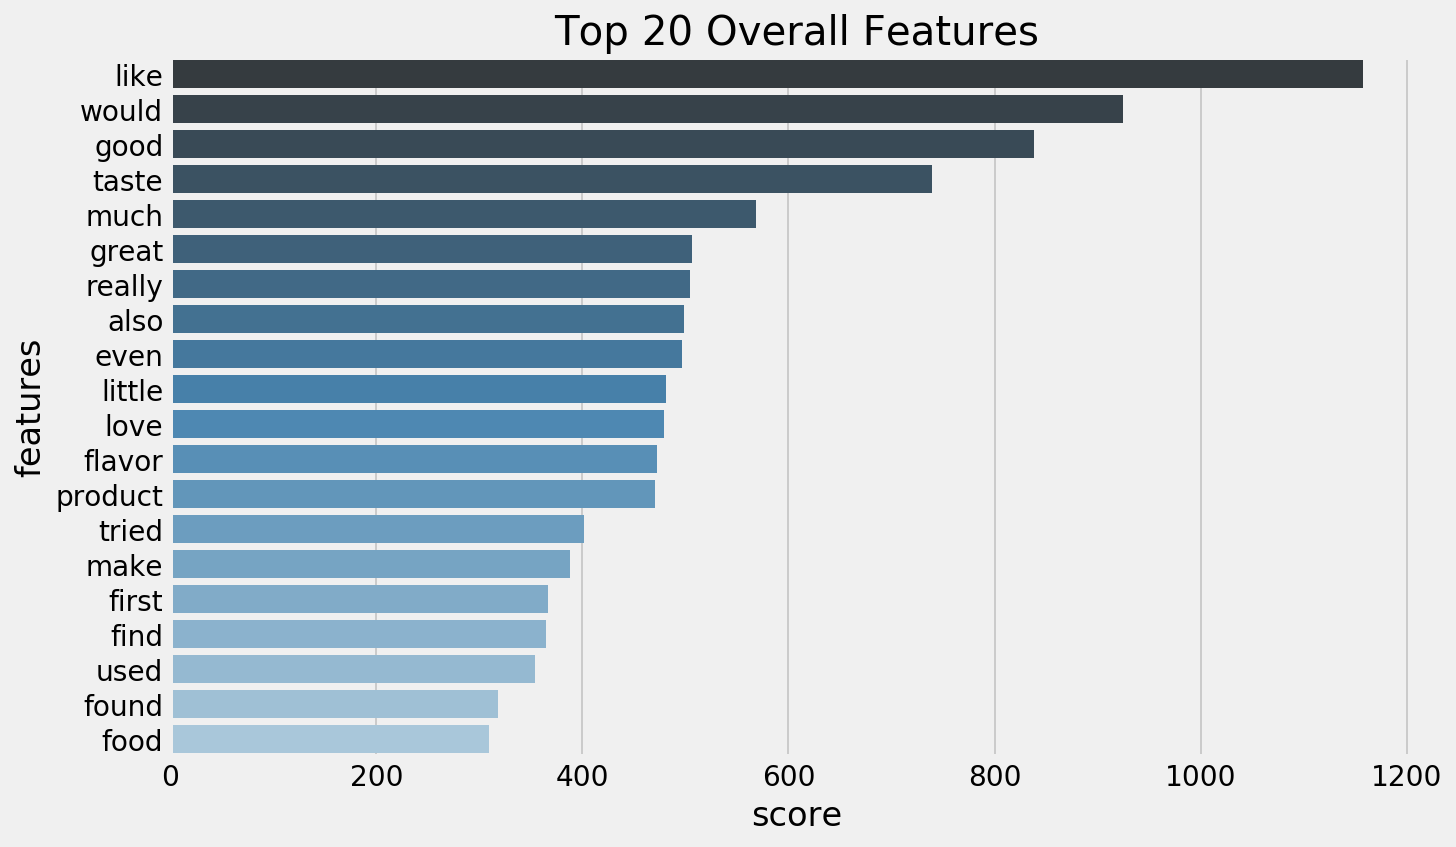

In [78]:
plt.style.use('fivethirtyeight')
sns.barplot(y='features', x='score', data=fimp, palette='Blues_d');
plt.title('Top 20 Overall Features');

### F1 score on the test data

In [79]:
xTest_bow = Dtest_bow
actuals_bow = yTest_bow

In [85]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

In [81]:
preds_bow = clf.predict(xTest_bow)

In [86]:
acs_bow = round(accuracy_score(actuals_bow, preds_bow), 5)
pre_bow = round(precision_score(actuals_bow, preds_bow), 5)
rec_bow = round(recall_score(actuals_bow, preds_bow), 5)
f1_bow = round(f1_score(actuals_bow, preds_bow), 5)
auc_bow = round(roc_auc_score(actuals_bow, preds_bow), 5)

In [87]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ['Vectorization', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x.add_row(['BOW', acs_bow, pre_bow, rec_bow, f1_bow, auc_bow])
print(x)

+---------------+----------+-----------+---------+---------+---------+
| Vectorization | Accuracy | Precision |  Recall |    F1   |   AUC   |
+---------------+----------+-----------+---------+---------+---------+
|      BOW      | 0.86461  |  0.96193  | 0.87041 | 0.91388 | 0.85379 |
+---------------+----------+-----------+---------+---------+---------+


In [88]:
from sklearn.metrics import confusion_matrix

In [89]:
cm_bow = pd.DataFrame(confusion_matrix(actuals_bow, preds_bow),
             columns=['negative', 'positive'], index=['negative', 'positive'])

In [90]:
cm_bow

,negative,positive
negative,15970,3106
positive,11684,78476
